# Determine the physical input parameter

In [1]:
from IPython.display import Math

# ---INPUT---------------------------------------------
d_1 = 8e-6              # diameter of the smaller cell [m]
d_2 = 12e-6             # diameter of the bigger cell [m]
tau_max = 20.0          # Maximum shear stress the cell can withstand without damage [Pa]
# ------------------------------------------------------

# ---VARIABLE-ASSUMPTION--------------------------------
R = 500e-6              # bend radius [m]
# ------------------------------------------------------

# ---FIXED-ASSUMPTIONS----------------------------------
rho = 1015              # density of water with 2% methylcellulose [kg/m^3]
mu  = 1e-3              # dyn. viscosity of water [Pa·s]
# ------------------------------------------------------

In [2]:
import numpy as np

H = ((1152 * mu**4 * R) / (rho**2))**(1/5)
Q = (80 * mu * np.sqrt(2 * R * H)) / rho
Re = (rho * Q) / (mu * H)
De = Re * np.sqrt(H / (2 * R))

print(f"H  = {H*1e6:.2f} µm")
print(f"Q  = {Q*60/1e-9:.2f} µL/min")
print(f"Re = {Re:.2f}")

H  = 223.61 µm
Q  = 2236.27 µL/min
Re = 169.18


# Calculate the background flow

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


Computation finished


/Users/jens.molge/PycharmProjects/Master-s-Thesis/firedrake_env/venv/lib/python3.11/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


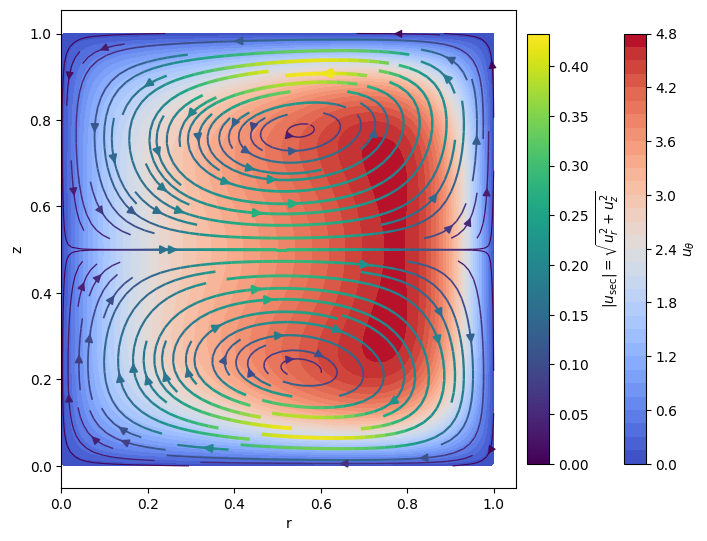

In [33]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt


# Firedrake uses UFl, which is why we can't just write 1.0
rho = Constant(1.0)
mu  = Constant(0.01)
R   = Constant(10.0)
# drop in pressure per unit arc-length along the centreline of the duct
G  = Constant(1.0)
H = 1.0
W = H


nx, nz = 60, 60
mesh = RectangleMesh(nx, nz, W, H, quadrilateral=True)
# "Q" => Tensorproduct-elements, 2 = degrees of the polynomials
V = VectorFunctionSpace(mesh, "Q", 2, dim=3)
Q = FunctionSpace(mesh, "Q", 1)
# Just the Cartesian product of V and Q
W_mixed = V * Q


# extracts a UFL expression for the coordinates of the mesh
x_mesh, z_mesh  = SpatialCoordinate(mesh)
# Initialise r and z so that (r,z) = (0,0) it is at the center of the cross-section
r = x_mesh - W/2
z = z_mesh - H/2


w = Function(W_mixed)
u, p = split(w)
v, q = TestFunctions(W_mixed)


# Transformation of the velocity components to our local coordinate system
u_r = u[0]
u_theta = u[2]
u_z = u[1]
v_r = v[0]
v_theta = v[2]
v_z = v[1]


# Shortcuts for readability
def del_r(f):  return Dx(f, 0)
def del_z(f):  return Dx(f, 1)

# weak form of the continuity equation
F_cont = q * ( del_r(u_r) + del_z(u_z) + u_r/(R + r) ) * (R + r) * dx

# weak form of the radial-component
F_r = (rho * (u_r * del_r(u_r) + u_z * del_z(u_r) - (u_theta**2) / (R + r)) * v_r
    + del_r(p) * v_r
    + mu * dot(grad(u_r), grad(v_r))
    + mu * ((1.0/(R + r)) * del_r(u_r) - (u_r / (R + r)**2)) * v_r) * (R + r) * dx


# weak form of the azimuthal-component of our transformed equation
F_theta = (rho * (u_r * del_r(u_theta) + u_z * del_z(u_theta) + (u_theta * u_r) / (R +r)) * v_theta
        - ((G*R) / (R + r)) * v_theta
        + mu * dot(grad(u_theta), grad(v_theta))
        + mu * ((1.0/(R + r)) * del_r(u_theta) - (u_theta / (R + r)**2)) * v_theta) * (R + r) * dx


# weak form of the z-component of our transformed equation
F_z = (rho * (u_r * del_r(u_z) + u_z * del_z(u_z)) * v_z
    + del_z(p) * v_z
    + mu * dot(grad(u_z), grad(v_z))
    + mu * ( (1.0/(R + r)) * del_r(u_z) ) * v_z) * (R + r) * dx

F = F_cont + F_theta + F_r + F_z


# When you define the problem the boundary conditions must apply to components of W_mixed, not to the stand-alone V, thats why we're using W_mixed.sub(0) = "First component of W_mixed"
no_slip = DirichletBC(W_mixed.sub(0), Constant((0.0, 0.0, 0.0)), "on_boundary")

# In Navier-Stokes, the pressure just appears in a differentiated form and is therefore unique except for a constant.
# A constant pressure is (because of a lack of boundary conditions for p) part of the kernel of the linearised operator
# If we give the solver the information where nullspaces are, it can ignore this direction while inverting the matrix in our Newton method
nullspace = MixedVectorSpaceBasis(W_mixed, [W_mixed.sub(0), VectorSpaceBasis(constant=True)])

problem = NonlinearVariationalProblem(F, w, bcs=[no_slip])

solver = NonlinearVariationalSolver(
    problem,
    nullspace=nullspace,
    solver_parameters={
        "snes_type": "newtonls",
        "snes_linesearch_type": "bt",      # backtracking (robuster)
        "snes_rtol": 1e-8,
        "snes_atol": 1e-10,
        "snes_max_it": 50,                 # >1 !
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        # optional Diagnose:
        # "snes_monitor": None,
        # "ksp_monitor_true_residual": None,
    },
)
# (Optional) initial guess; null ist ok
# w.assign(0)

solver.solve()
u_sol, p_sol = w.subfunctions
print("Computation finished")













# ------------------------------------------------------------
# Visualisierung: Dean-Vortices (Stromlinien der Sekundärströmung)
# ------------------------------------------------------------

# Plotraster (gleichmäßig über dem Rechteck)
coords = mesh.coordinates.dat.data_ro
xmin, xmax = float(coords[:, 0].min()), float(coords[:, 0].max())
zmin, zmax = float(coords[:, 1].min()), float(coords[:, 1].max())

nxp, nzp = 160, 160
xi = np.linspace(xmin, xmax, nxp)
zi = np.linspace(zmin, zmax, nzp)
Xi, Zi = np.meshgrid(xi, zi)

# Geschwindigkeit auf dem Raster auswerten
pts = np.column_stack([Xi.ravel(), Zi.ravel()])   # (nxp*nzp, 2)
U_at_list = u_sol.at(pts)                         # Liste von 3er-Vektoren (FutureWarning ist ok)

# Robust in ein (N,3)-Array umwandeln
try:
    U_at = np.asarray(U_at_list, dtype=float)
    if U_at.ndim != 2 or U_at.shape[1] != 3:
        raise ValueError
except Exception:
    U_at = np.vstack([np.asarray(v, dtype=float).ravel() for v in U_at_list])

# Komponenten und in Grid-Form bringen
Ur  = U_at[:, 0].reshape(nzp, nxp)
Uz  = U_at[:, 1].reshape(nzp, nxp)
Uth = U_at[:, 2].reshape(nzp, nxp)

# Sekundärgeschwindigkeit (für Farbe/Linienstärke)
Speed = np.sqrt(Ur**2 + Uz**2)
Speed[~np.isfinite(Speed)] = 0.0
Ur[~np.isfinite(Ur)] = 0.0
Uz[~np.isfinite(Uz)] = 0.0

# Linienbreite dezent nach |u_sec|
eps = 1e-14
lw = 0.8 + 2.0 * (Speed / (Speed.max() + eps))

# ---- Plot ----
fig, ax = plt.subplots(figsize=(7.5, 5.5))
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("r")
ax.set_ylabel("z")

# Hintergrund: u_theta
cf = ax.contourf(Xi, Zi, Uth, levels=40, cmap="coolwarm")
cbar1 = fig.colorbar(cf, ax=ax, shrink=0.9, pad=0.02)
cbar1.set_label(r"$u_\theta$")

# Stromlinien der Sekundärströmung
strm = ax.streamplot(
    xi, zi, Ur, Uz,
    density=1.4,
    color=Speed,
    linewidth=lw,
    cmap="viridis",
    arrowsize=1.2,
    minlength=0.1
)
cbar2 = fig.colorbar(strm.lines, ax=ax, shrink=0.9, pad=0.02)
cbar2.set_label(r"$|u_{\mathrm{sec}}| = \sqrt{u_r^2 + u_z^2}$")

plt.tight_layout()
plt.show()

# Calculate the perturbed flow